# Imports

In [2]:
%matplotlib notebook
import sys, os, time, h5py, sys, pickle, matplotlib, random  
sys.path.insert(0, "/home/ruthvik/Desktop/Summer 2017/SpykeFlow")
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  ## GPU is not used, set to 0 if you want a GPU
import numpy as np
import spykeflow as sf
from spykeflow import network as network
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from spykeflow import inputlayerclass as inputlayer
np.random.seed(0)
from IPython.display import display, HTML



Prepping the MNIST data .... 

Finished MNIST data ..

Prepping the EMNIST data .... 

Finished EMNIST data ..

Prepping the CIFAR100 data .... 

Unable to find data in AllDataSets/cifar100..
Prepping the CIFAR10 data .... 

Unable to find data in AllDataSets/cifar10..


# Hide Code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Encoding input data (L1)
* You can load a stored spike data or encode a new dataset
* To encode, place the files either in the `AllDataSets` folder.
* Follow the README in the `AllDataSets` folder for more info.

In [4]:
############### PREPARE THE SPIKE DATA ################## dataset can be mnist, emnist, cifar100,cifar10, caltech101, caltech256
T1 = time.time()
tsteps = 12
test_frac = 1.0/7
val_frac=test_frac
data_set = 'facemotor'

        #### grabbing testing data ###########
firstLayer = inputlayer.InputLayer(debug= not True, size=161, dataset=data_set, off_threshold=15,\
                                   on_threshold=15, border_size=2, data='test', val_frac=val_frac, test_frac=test_frac)
test_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]


        #### grabbing training data ###########
firstLayer = inputlayer.InputLayer(debug= not True, size=161, dataset=data_set, off_threshold=15,\
                                   on_threshold=15, border_size=2, data='train', val_frac=val_frac, test_frac=test_frac)
train_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]

        #### grabbing validation data ###########
firstLayer = inputlayer.InputLayer(debug= not True,size=161,dataset=data_set,off_threshold=15,\
                                   on_threshold=15,border_size=2,data='valid',val_frac = val_frac,test_frac = test_frac)
valid_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]



        ##### combine the training and validation data so that the classifier class can split it inside the keras library #######
train_input_data.extend(valid_input_data)
random.shuffle(train_input_data)
labels_map = {0:'Face', 1:'Motor'}

       ###### convert the vectorized labels to integer values #######

class_labels_train = map(lambda x: x[1].max(), train_input_data)
sample_interval=100
nofImages = len(train_input_data)
intervals = nofImages/sample_interval
temp_input_data = [items[0] for items in train_input_data][0:nofImages]
temp_input_data = np.concatenate(temp_input_data, axis=3)
train_input_images = temp_input_data
size = train_input_images.shape[0]
plots = False

# Train the first convolution layer (L2)
* Because as we are using a dataset (faces and bikes from CALTECH101) we have lot of spikes so we set `few_spikes=False`. 

In [7]:
############## INITIALIZE AND TRAIN THE 1ST CONVOLUTION LAYER ############
train_input_images[:,:,1,:] = 0 ##kill all off center spikes
l1_maps = 4
nTrain_images = 400
print('Number of training images:{}'.format(nTrain_images))
net1 = network.Network(homeostasis_const=1, factor=5.0, pool_lateral_inh= False, output_channels=l1_maps, \
            input_channels=2, inputs=train_input_images[:,:,:,0:12*nTrain_images], A_plus=0.002, debug=False, \
            sample_interval=sample_interval, train=True, save_pool_spike_tensor=False, save_pool_features=False,\
            homeo_supp_coeff=0.003, threshold=10.0, size=size, few_spikes=False, epochs=5, lr_inc_rate=500, weight_sigma=0.02)
net1.weights[:,:,:,1,:] = 0 ##kill all synapses for OFF center
net1.feedforward()

Number of training images:400
Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4 161 162 163 164 165 322 323 324 325 326 483 484 485
 486 487 644 645 646 647 648]

connections of last neuron in the maps to neurons in input image(prev_map):
[25272 25273 25274 25275 25276 25433 25434 25435 25436 25437 25594 25595
 25596 25597 25598 25755 25756 25757 25758 25759 25916 25917 25918 25919
 25920]

There are:(161, 161) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:2 previous maps and there are:4 input maps
Images trained so far:1
current A_plus:0.004, A_minus:0.003, tstep:0, epoch:0


Epoch:0 is done!


Images trained so far:500
current A_plus:0.008, A_minus:0.006, tstep:1199, epoch:1


Epoch:1 is done!


Images trained so far:1000
current A_plus:0.016, A_minus:0.012, tstep:2398, epoch:2


Epoch:2 is done!


Images trained so far:1500
current A_plus:0.032, A_minus:0.024, tstep:3597, epoch:3


Epoch:3 is done!


Images trained so far:2000
current A_plus:0.064, A_minus:0.048, tstep:4796, epoch:4
Epoch:4 is done!


## Plot and visualize filters in first convolution layer (L2)

<IPython.core.display.Javascript object>


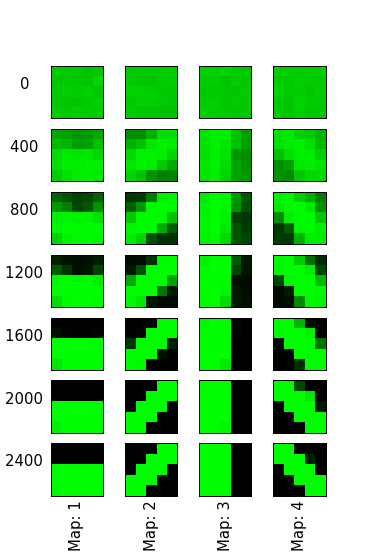

In [12]:
nofImages = 2400
new_sample_interval=400
new_intervals = nofImages/new_sample_interval
skips = new_sample_interval/sample_interval
fig = net1.feature_visualization([net1.evol_weights[::skips]], new_sample_interval, new_intervals,\
                                 figsize=(4,2), font1=12, font2=12)

## Animate the evolution of filters

<IPython.core.display.Javascript object>


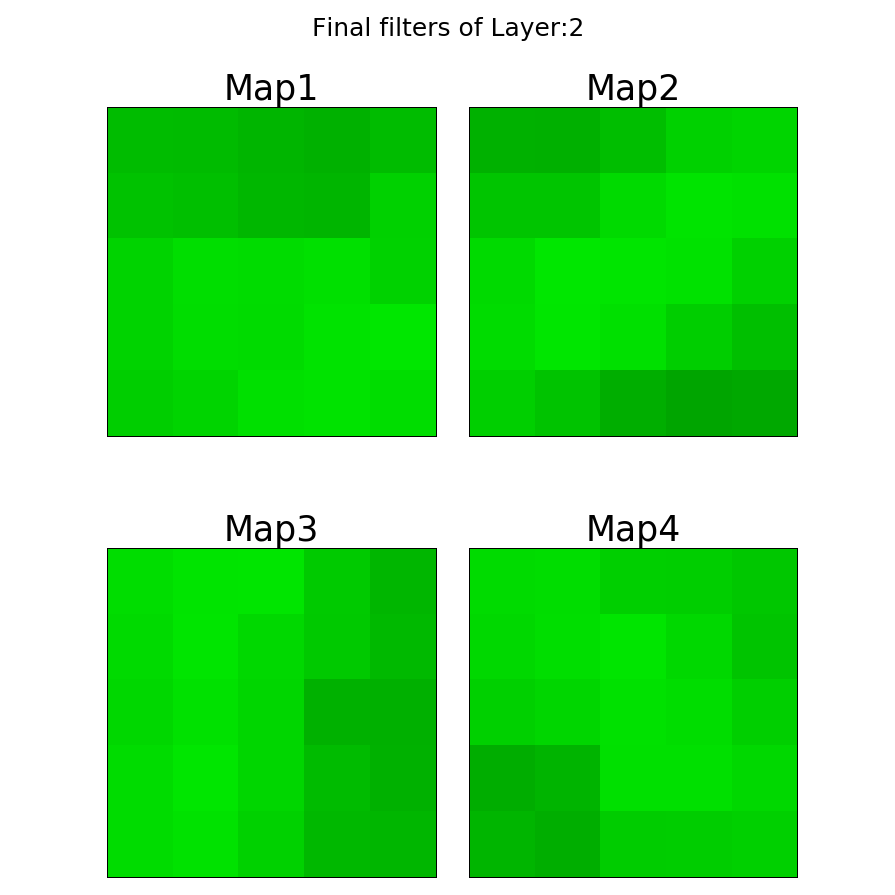

In [16]:
animation, fig = net1.animation([net1.evol_weights], plotx=2, ploty=2, sample_interval=sample_interval,\
                                intervals=intervals, currLayer=2, font1=28)

In [17]:
HTML(animation.to_html5_video())

## Feature convergence of L2 layer

<IPython.core.display.Javascript object>


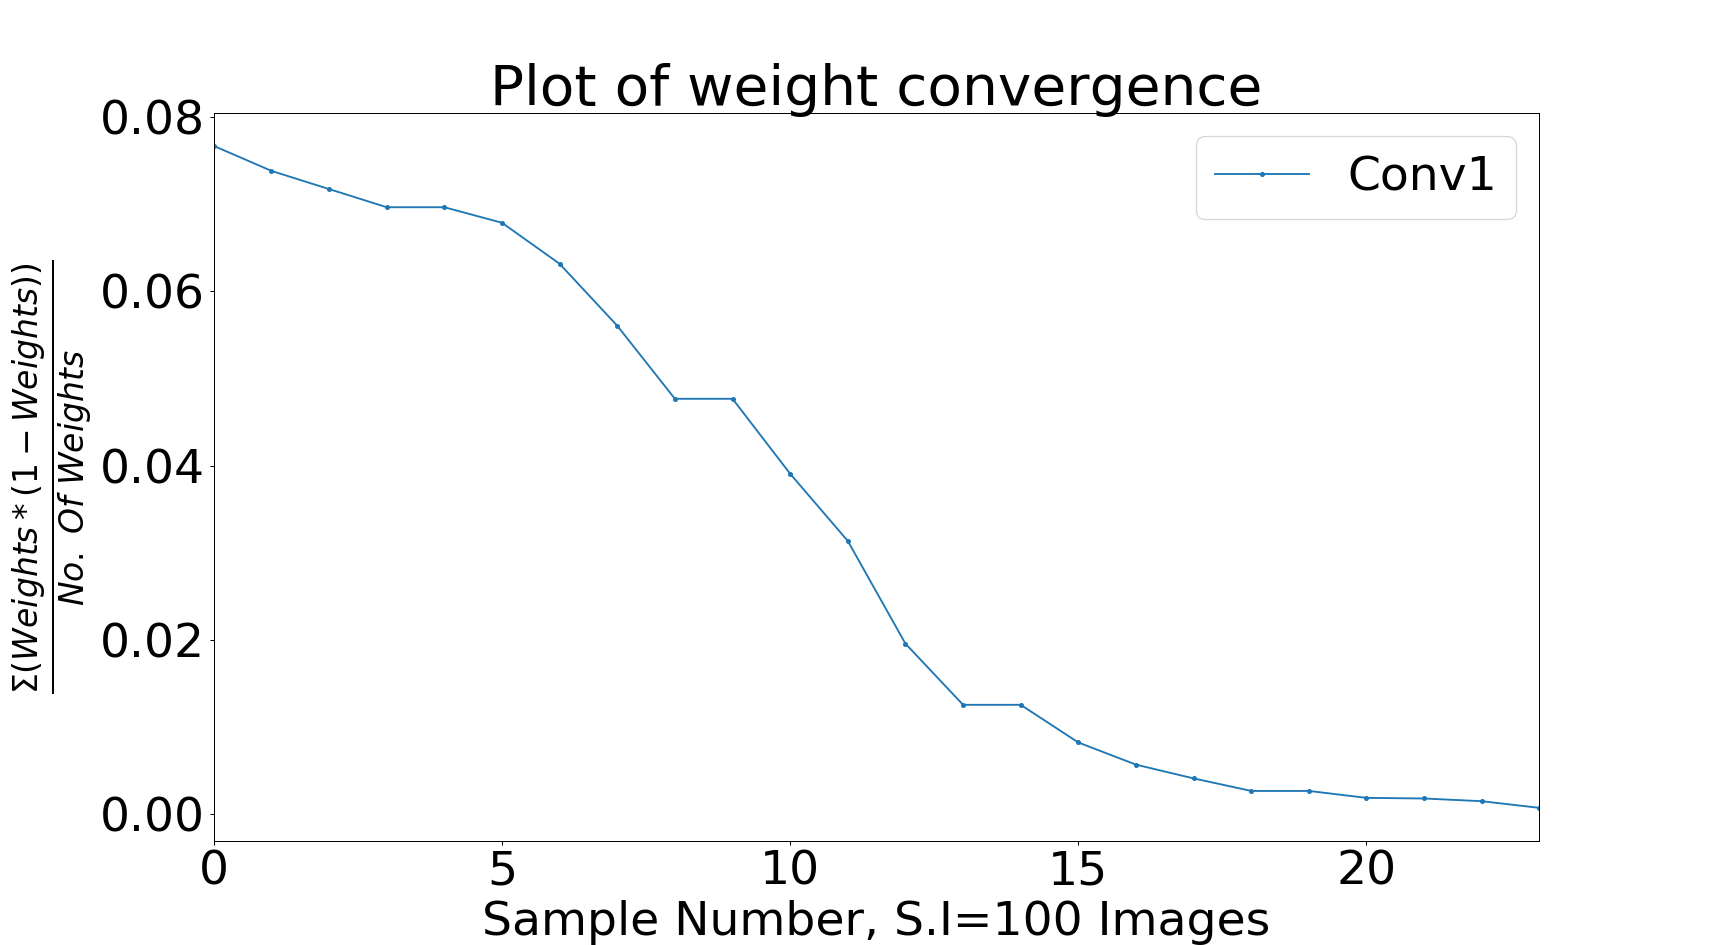

<IPython.core.display.Javascript object>


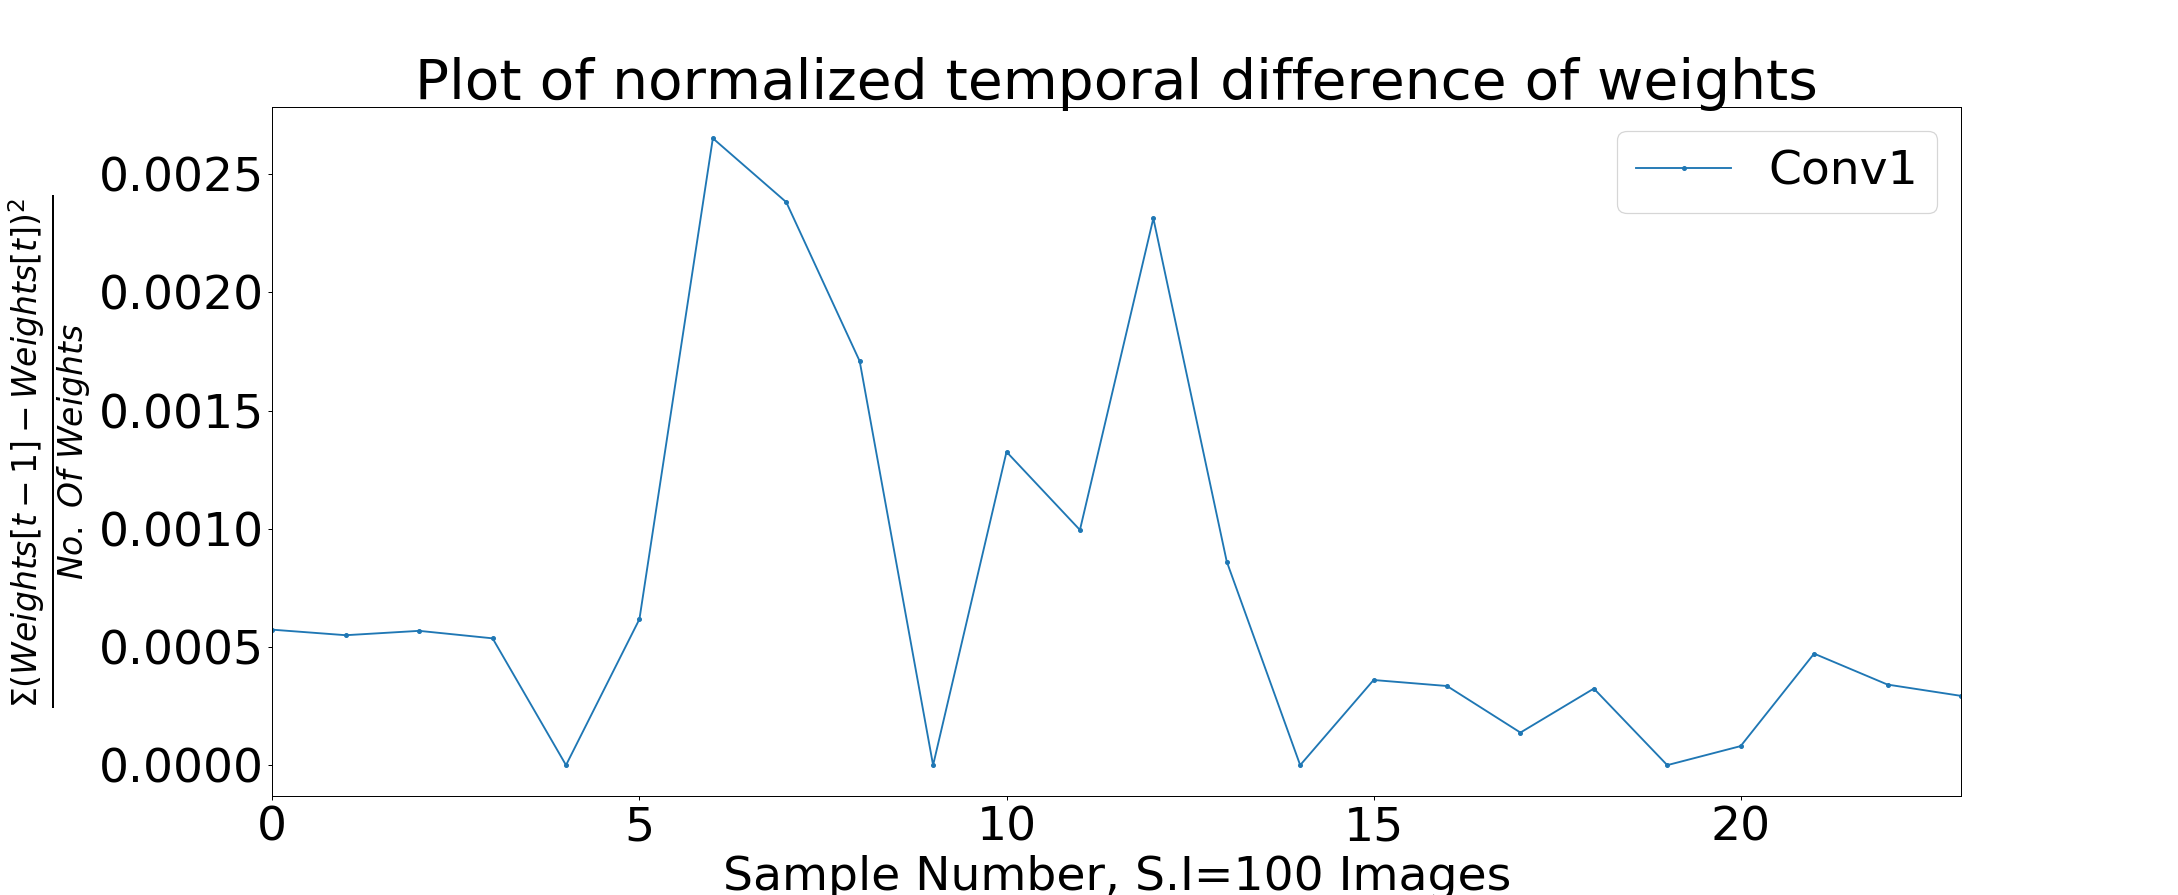

In [24]:
net1.feature_convergence([net1.evol_weights], sample_interval, font_size=38)

## Spike statistics of L2 layer

<IPython.core.display.Javascript object>


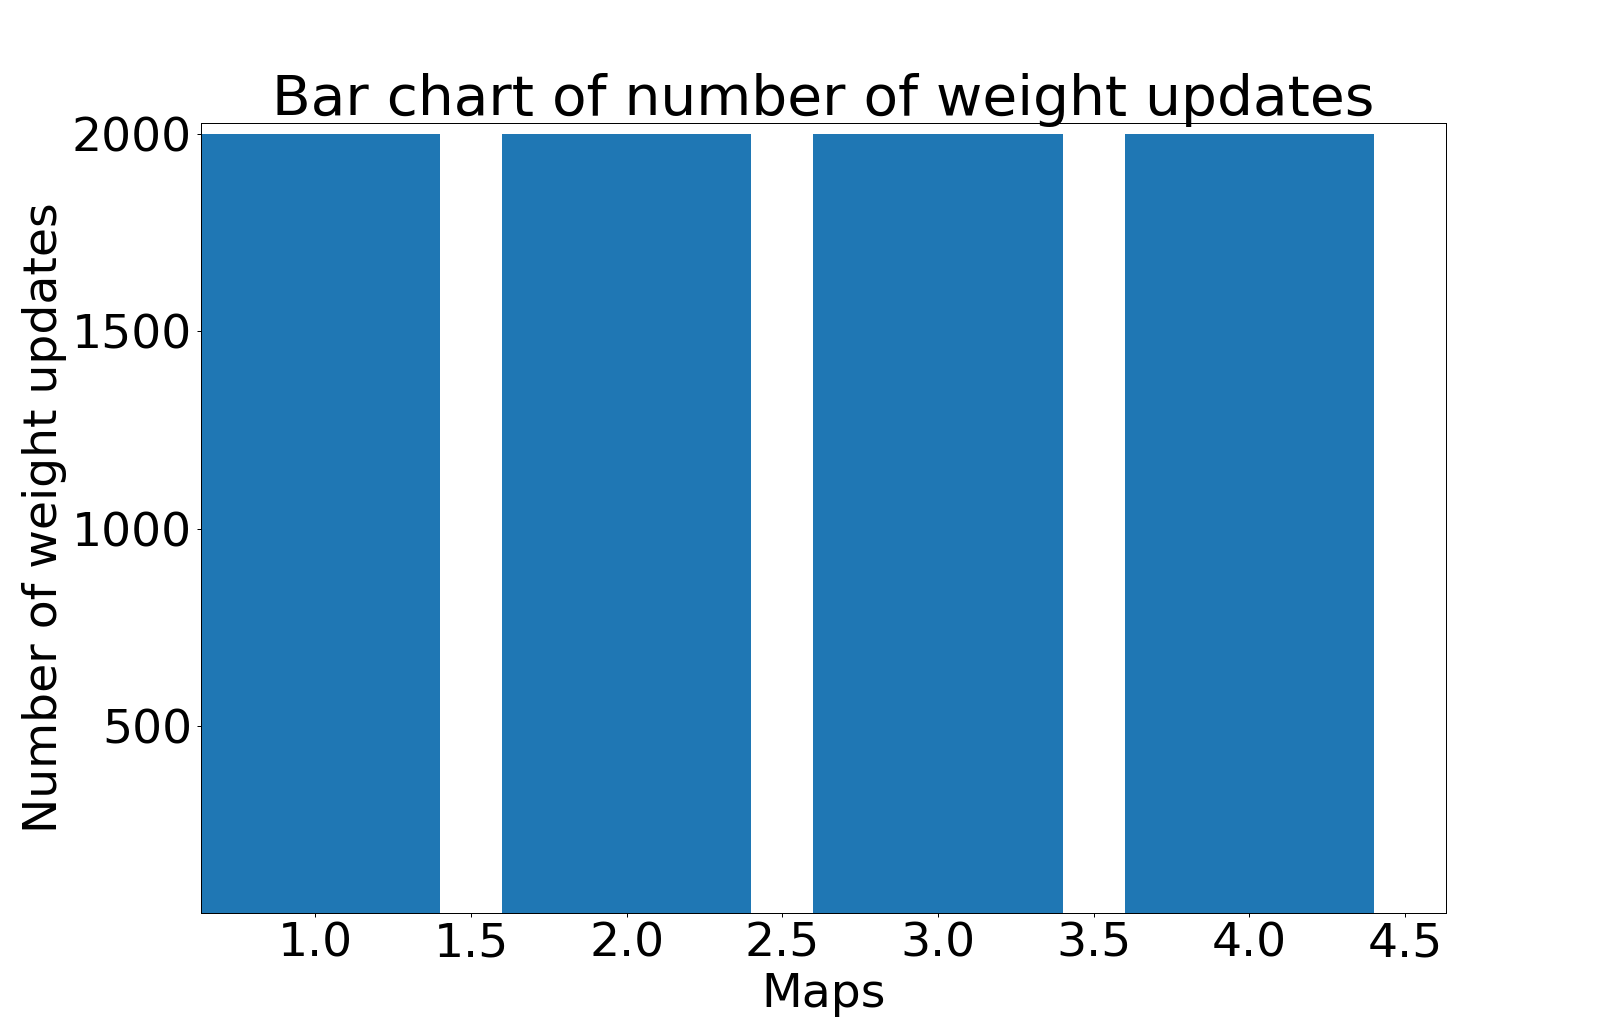

<IPython.core.display.Javascript object>


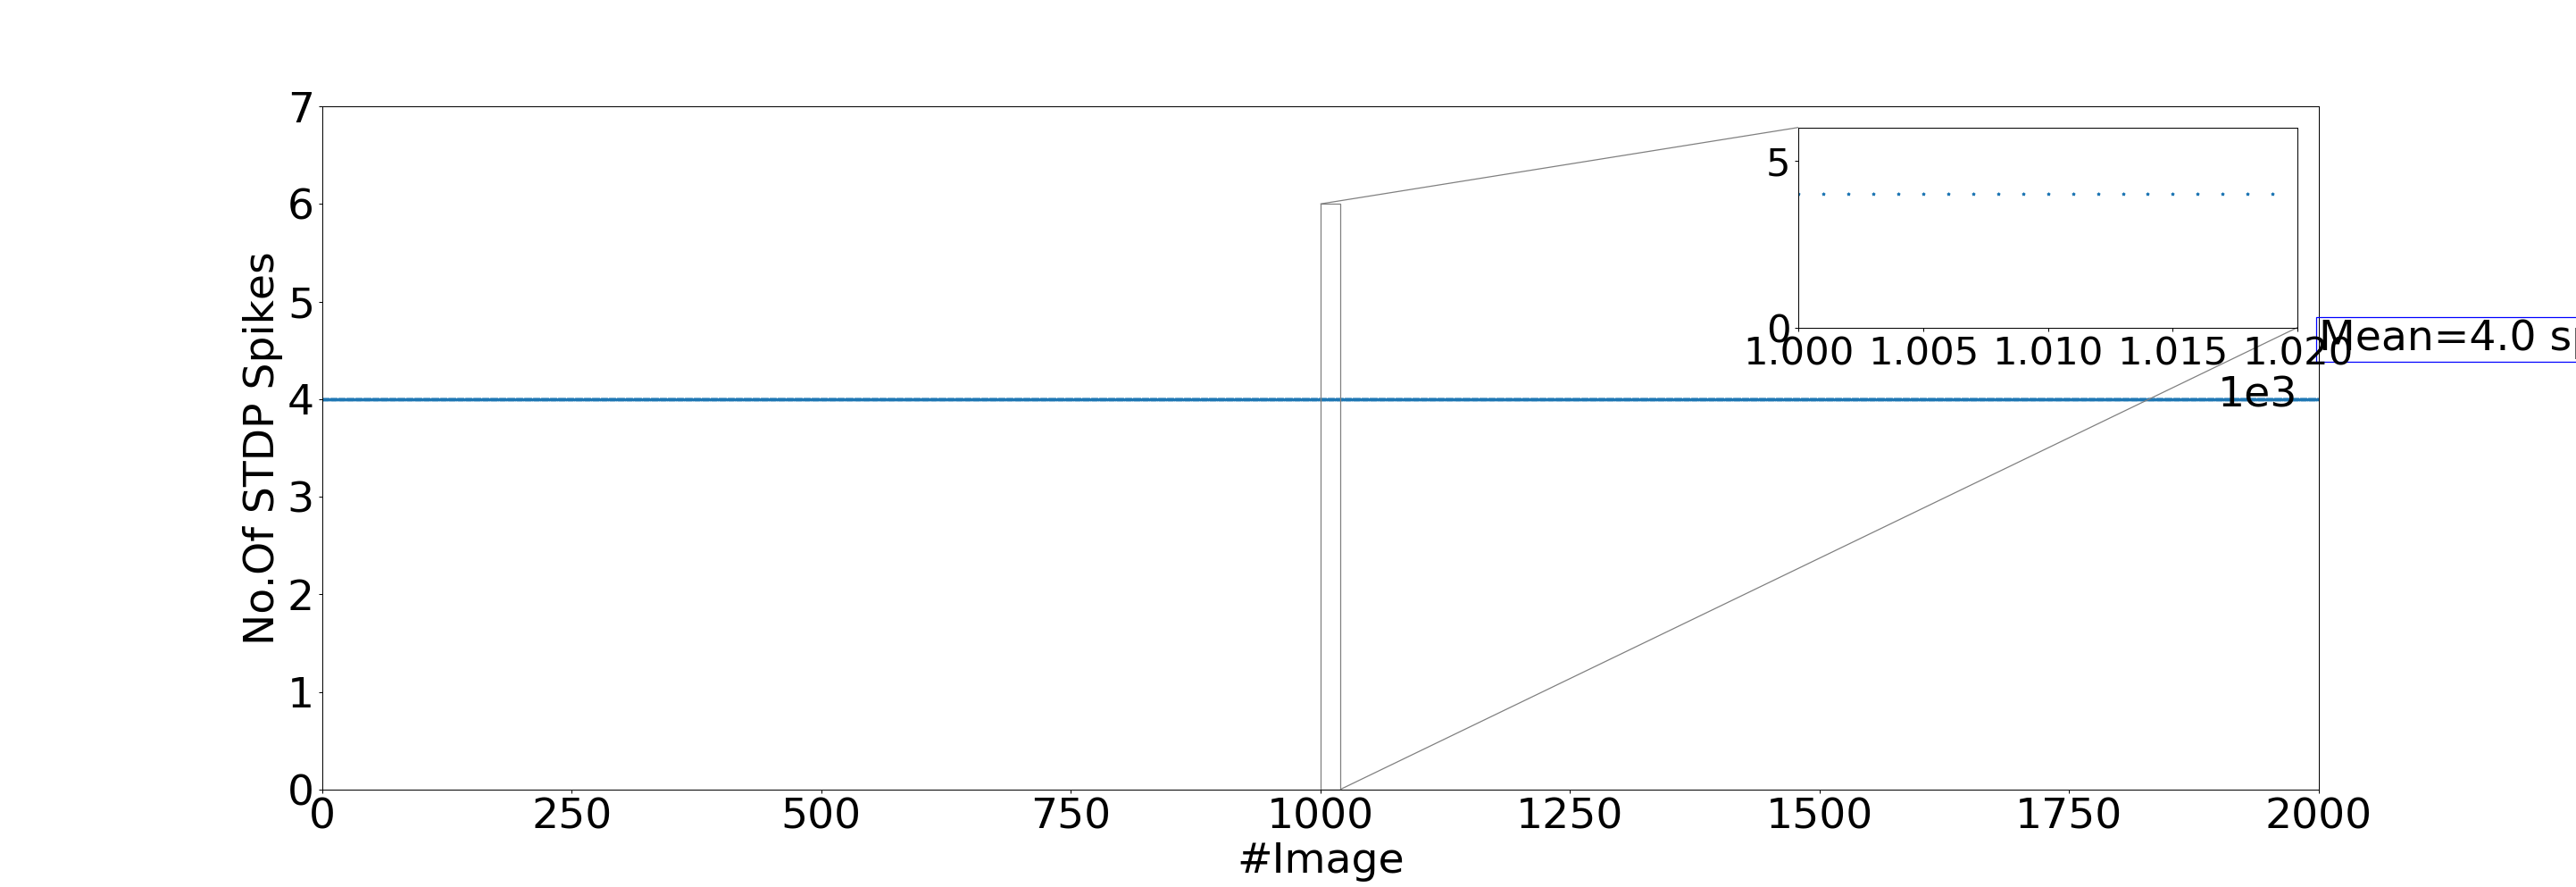

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a70210250>)

In [26]:
net1.spike_statistics()

# Fix the weights of L2 and collect spikes in pool1 (L3)
* Collect spikes in L3 without enforcing lateral inhbition in L3 and limiting number of spikes per neuron per image to one by setting `pool_lateral_inh=True ` and `pool_spike_accum=False` respectively.
* Collected spikes can be used to train the subsequent convolution layers or create feature vectors 
* At this stage **only lateral inhibition** is applied in L2 and **no STDP competition is applied** as learning is already done.

In [27]:
evolved_weights = net1.evol_weights[-1]
net2 = network.Network(pool_lateral_inh=True, inputs=train_input_images[:,:,:,0:12*nTrain_images], input_channels=2,\
                       output_channels=l1_maps,train=False, set_weights=evolved_weights, \
                       debug=False, save_pool_spike_tensor=True, save_pool_features=True, threshold=10.0,\
                       pool_spike_accum=False, pool_kernel_size=7, size=size)
net2.rewire_weights() ## fixing the weights
net2.feedforward()
pool1_spikes = net2.pool_spike_tensor

Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4 161 162 163 164 165 322 323 324 325 326 483 484 485
 486 487 644 645 646 647 648]

connections of last neuron in the maps to neurons in input image(prev_map):
[25272 25273 25274 25275 25276 25433 25434 25435 25436 25437 25594 25595
 25596 25597 25598 25755 25756 25757 25758 25759 25916 25917 25918 25919
 25920]

There are:(161, 161) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:2 previous maps and there are:4 input maps


Epoch:0 is done!


## Plot spikes per map per label in L3
* Note that the colors of ON and OFF filters are flipped here in the insets and need to be fixed by passing the feature tensor with OFF filter at 0th axis and ON at 1st axis.
* Use `temp = np.flip(net1.evol_weights[-1], axis=2)` and then set `final_weights=temp` to correct for that.

<IPython.core.display.Javascript object>


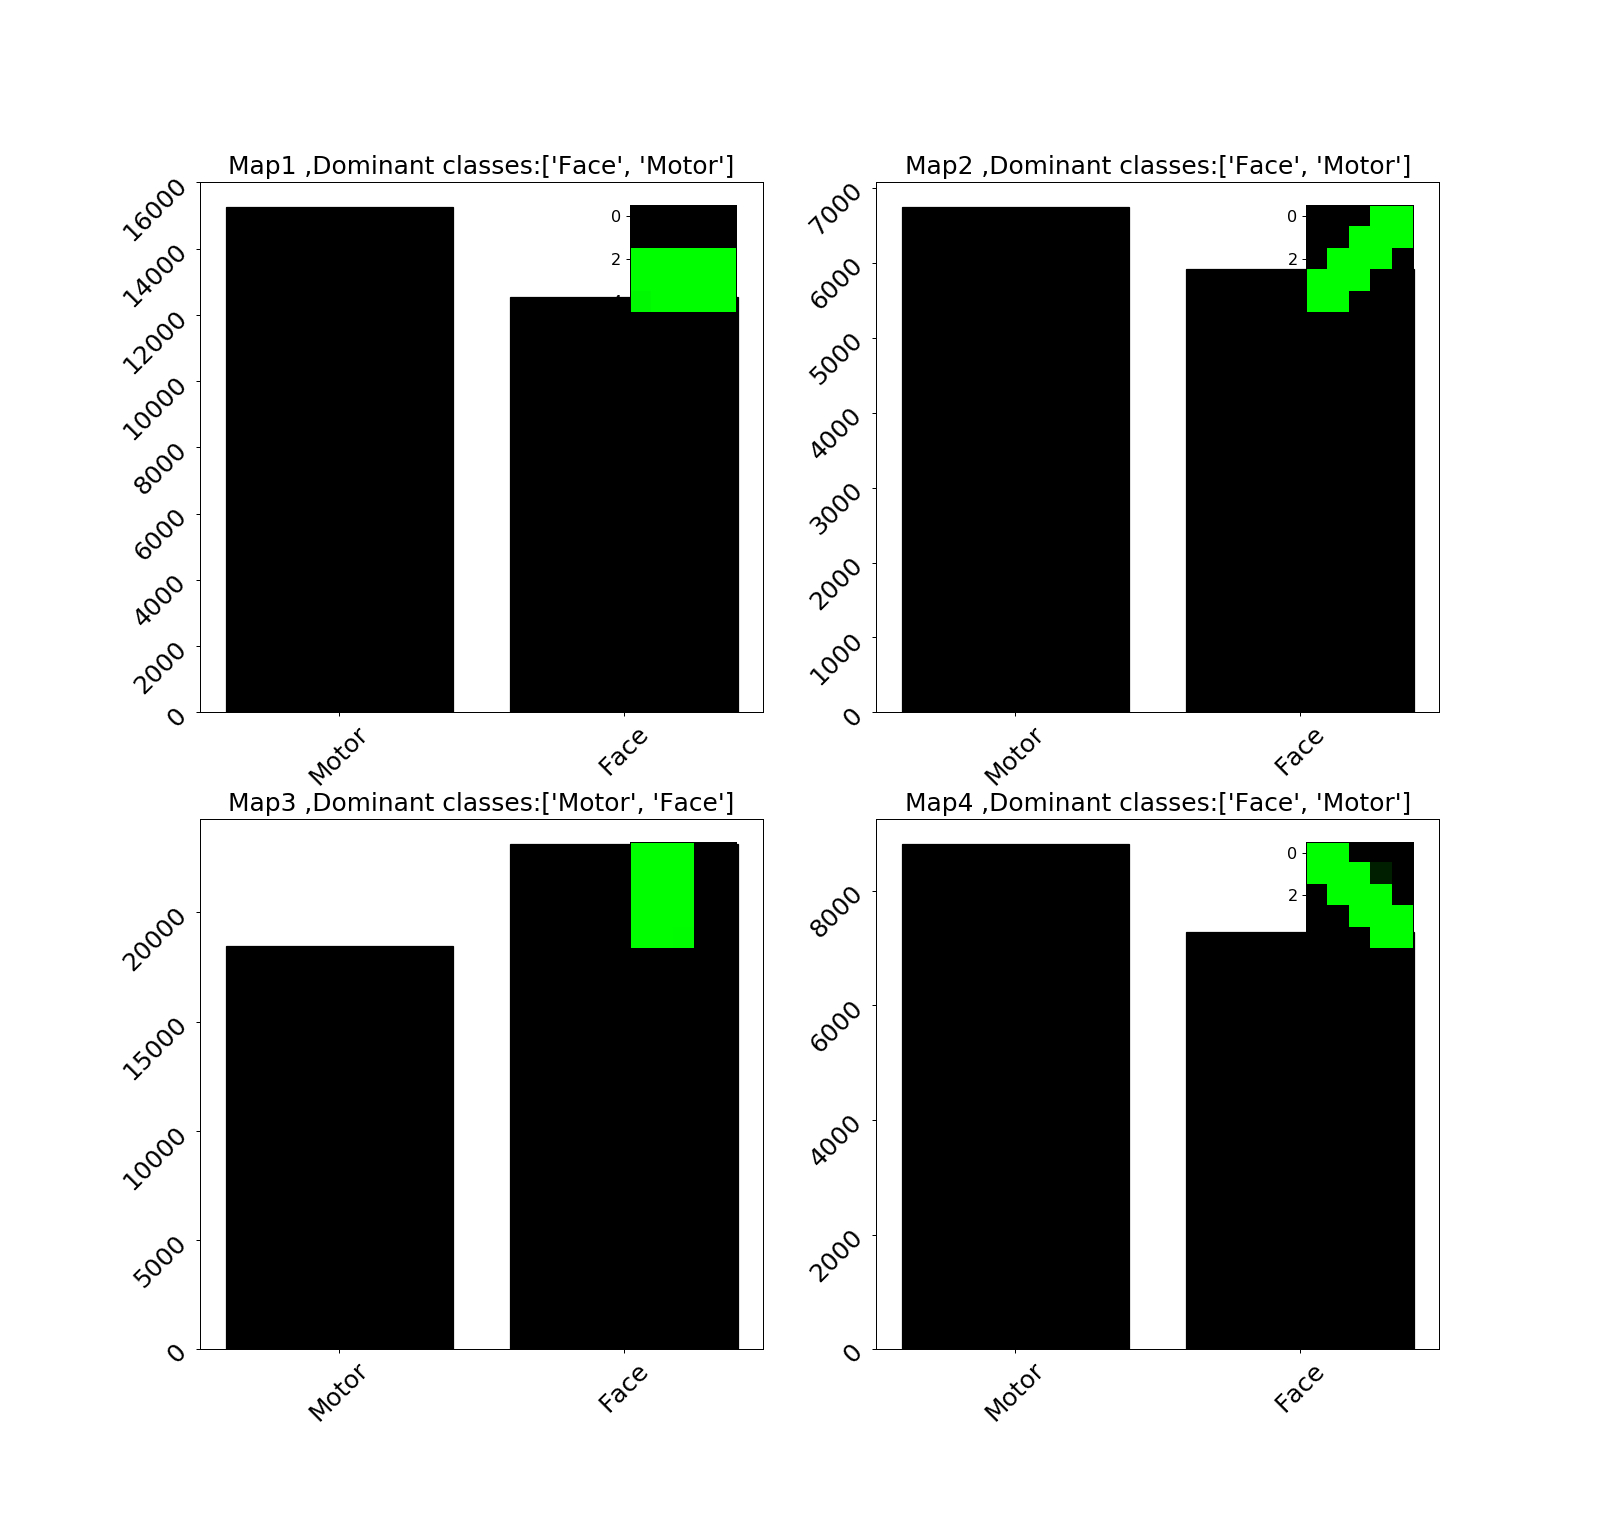

TOTAL NUMBER OF SPIKES IN POOL1 TIME TENSOR IN PLOTS:98159
TOTAL NUMBER OF SPIKES IN POOL1 TIME TENSOR:98159


In [35]:
temp = np.flip(net1.evol_weights[-1], axis=2)
fig = net2.spikes_per_map_per_class(plot_x=2,plot_y=2,class_labels=class_labels_train,\
                                    pool_output_data=net2.pool_spike_tensor,\
    labels_map=labels_map, font_size=20, inset_tick_size=13, tick_size=20, view_maps=[1, 2, 3, 4],\
                                    final_weights=temp,\
                                    figsize=(12.5,9.75))


In [36]:
print('Shape of spike tensor:{}'.format(net2.pool_spike_tensor.shape))
nSpikesL3 = net2.pool_spike_tensor.sum()
print('Average spikes per image in L3:{}'.format(nSpikesL3/(train_input_images.shape[-1]/12)))

Shape of spike tensor:(22, 22, 4, 4800)
Average spikes per image in L3:241


# Train Conv2 (L4) with spikes collected from L3
 * Here, we use spikes that were collected in L3 with lateral inhibition

In [37]:
T3 = time.time()
sample_interval = 100
l4_maps = 20
size = pool1_spikes.shape[0]
input_channels = pool1_spikes.shape[2]
nTrain_images = nofImages 
net3 = network.Network(inputs=pool1_spikes,A_plus=0.0004, debug=False, output_channels=l4_maps, size=size,\
                       input_channels=input_channels, lr_inc_rate=500, sample_interval=sample_interval,\
                       train=True, threshold=60.0, inh_reg=5, epochs=20, few_spikes=False, conv_kernel_size=17)

net3.feedforward()
print('Time for training Conv2:{}'.format(time.time()-T3))

Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 264 265 266 267 268 269 270 271 272 273 274 275
 276 2

Epoch:0 is done!


Images trained so far:500
current A_plus:0.0016, A_minus:0.0012, tstep:1199, epoch:1


Epoch:1 is done!


Images trained so far:1000
current A_plus:0.0032, A_minus:0.0024, tstep:2398, epoch:2


Epoch:2 is done!


Images trained so far:1500
current A_plus:0.0064, A_minus:0.0048, tstep:3597, epoch:3


Epoch:3 is done!


Images trained so far:2000
current A_plus:0.0128, A_minus:0.0096, tstep:4796, epoch:4
Epoch:4 is done!


Epoch:5 is done!


Images trained so far:2500
current A_plus:0.0256, A_minus:0.0192, tstep:1195, epoch:6


Epoch:6 is done!


Images trained so far:3000
current A_plus:0.0512, A_minus:0.0384, tstep:2394, epoch:7


Epoch:7 is done!


Images trained so far:3500
current A_plus:0.1024, A_minus:0.0768, tstep:3593, epoch:8


Epoch:8 is done!


Images trained so far:4000
current A_plus:0.15, A_minus:0.1125, tstep:4792, epoch:9
Epoch:9 is done!


Epoch:10 is done!


Images trained so far:4500
current A_plus:0.15, A_minus:0.1125, tstep:1191, epoch:11


Epoch:11 is done!


Images trained so far:5000
current A_plus:0.15, A_minus:0.1125, tstep:2390, epoch:12


Epoch:12 is done!


Images trained so far:5500
current A_plus:0.15, A_minus:0.1125, tstep:3589, epoch:13


Epoch:13 is done!


Images trained so far:6000
current A_plus:0.15, A_minus:0.1125, tstep:4788, epoch:14
Epoch:14 is done!


Epoch:15 is done!


Images trained so far:6499
current A_plus:0.15, A_minus:0.1125, tstep:1187, epoch:16


Epoch:16 is done!


Images trained so far:6999
current A_plus:0.15, A_minus:0.1125, tstep:2386, epoch:17


Epoch:17 is done!


Images trained so far:7499
current A_plus:0.15, A_minus:0.1125, tstep:3585, epoch:18


Epoch:18 is done!


Images trained so far:7999
current A_plus:0.15, A_minus:0.1125, tstep:4784, epoch:19
Epoch:19 is done!
Time for training Conv2:73.7866590023


## Feature convergence plot

<IPython.core.display.Javascript object>


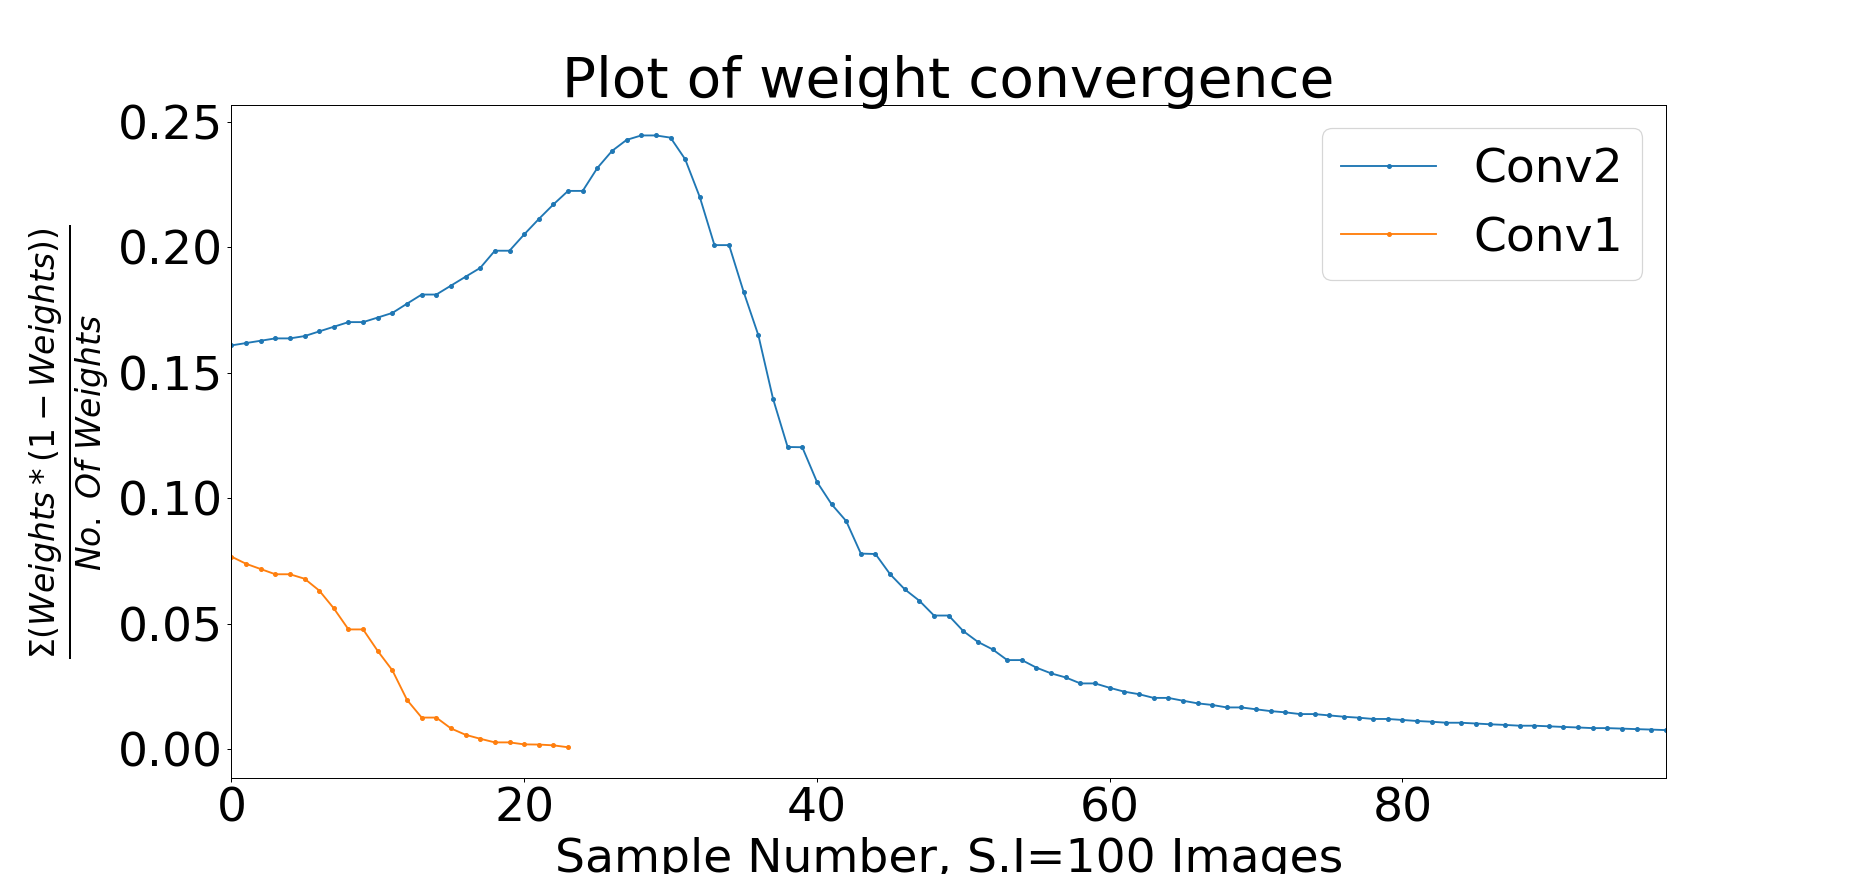

<IPython.core.display.Javascript object>


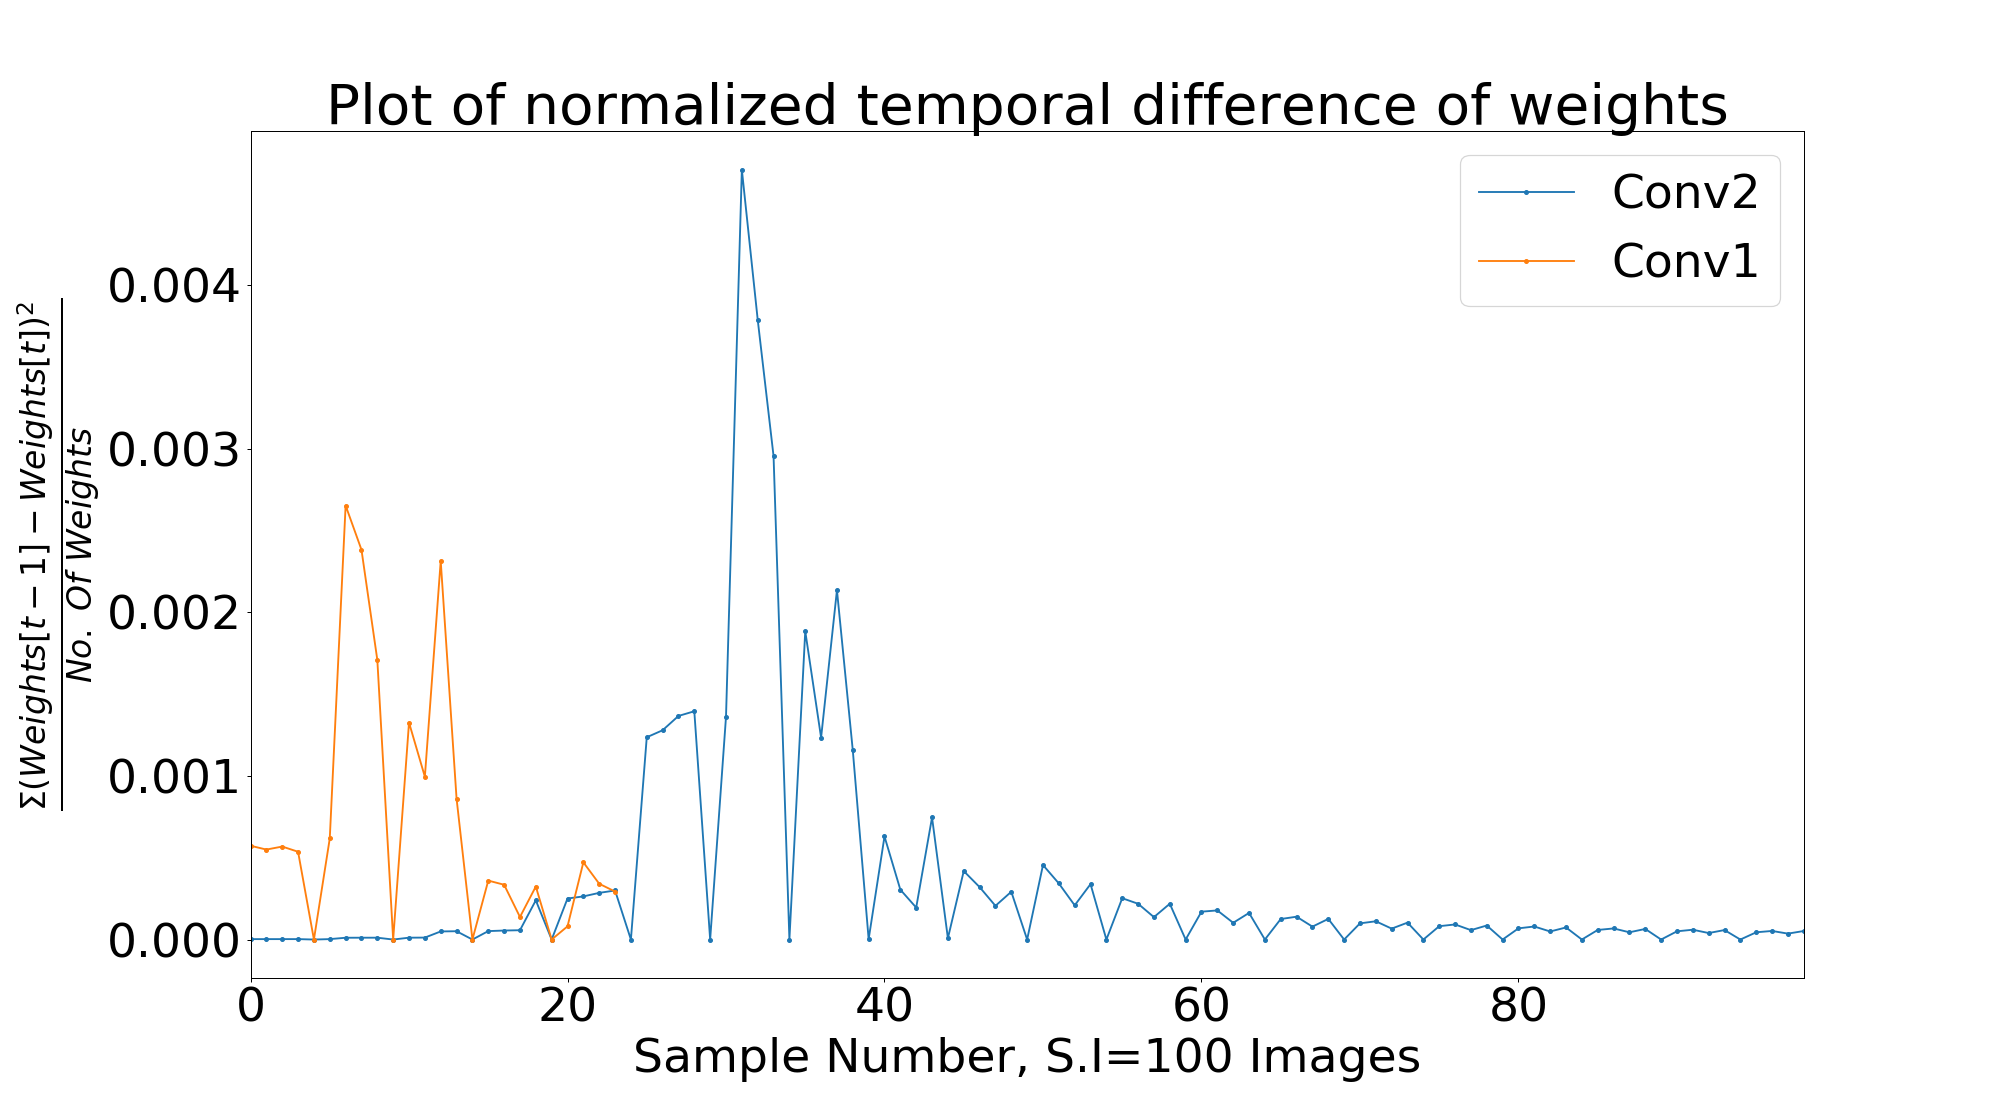

In [39]:
net3.feature_convergence([net1.evol_weights,net3.evol_weights],sample_interval)

## Spike statistics for L4

<IPython.core.display.Javascript object>


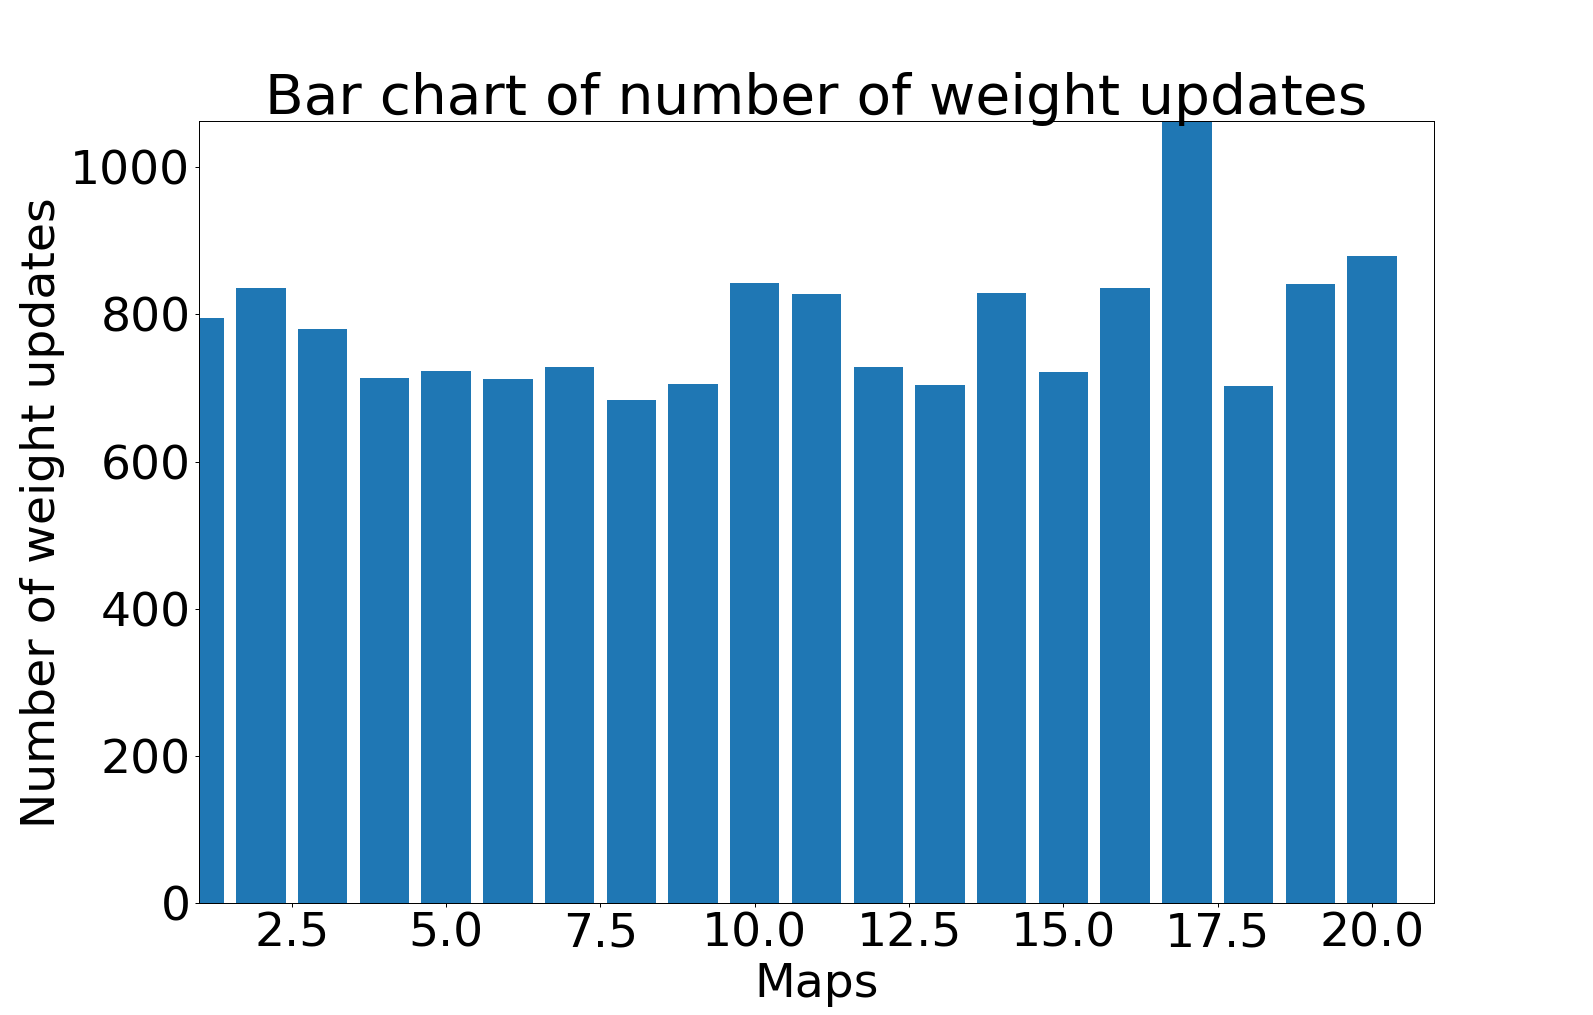

<IPython.core.display.Javascript object>


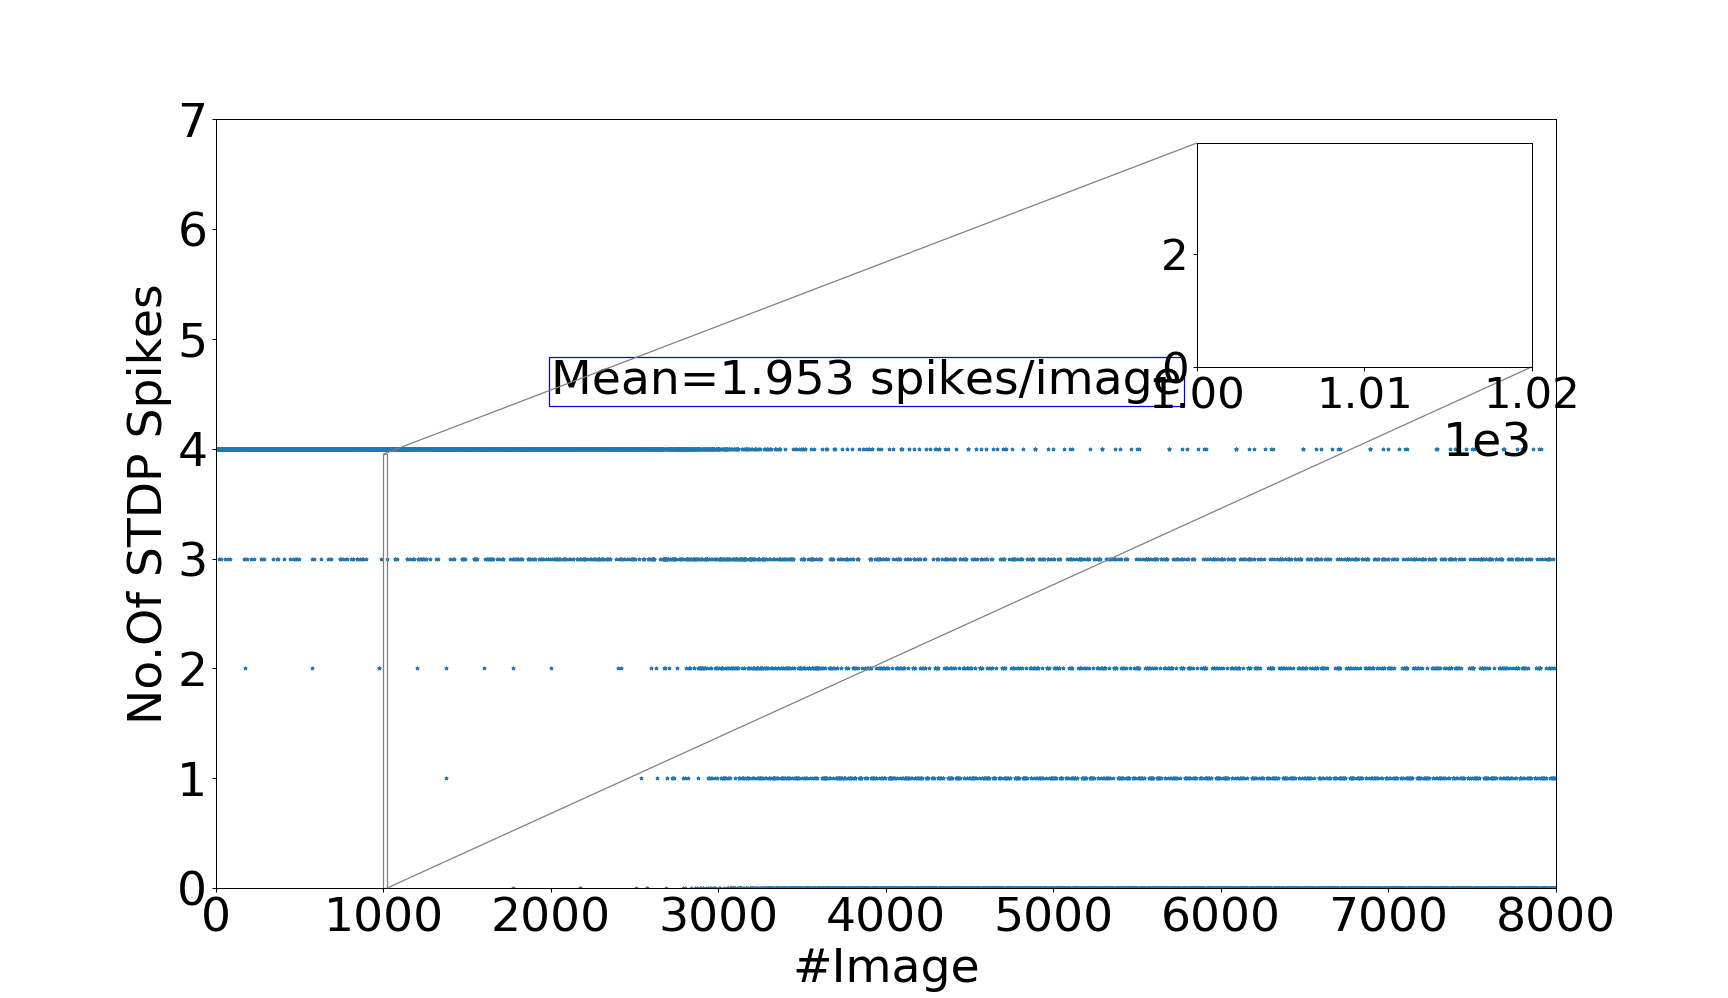

In [40]:
fig = net3.spike_statistics()

## Feature visualization for L4

<IPython.core.display.Javascript object>


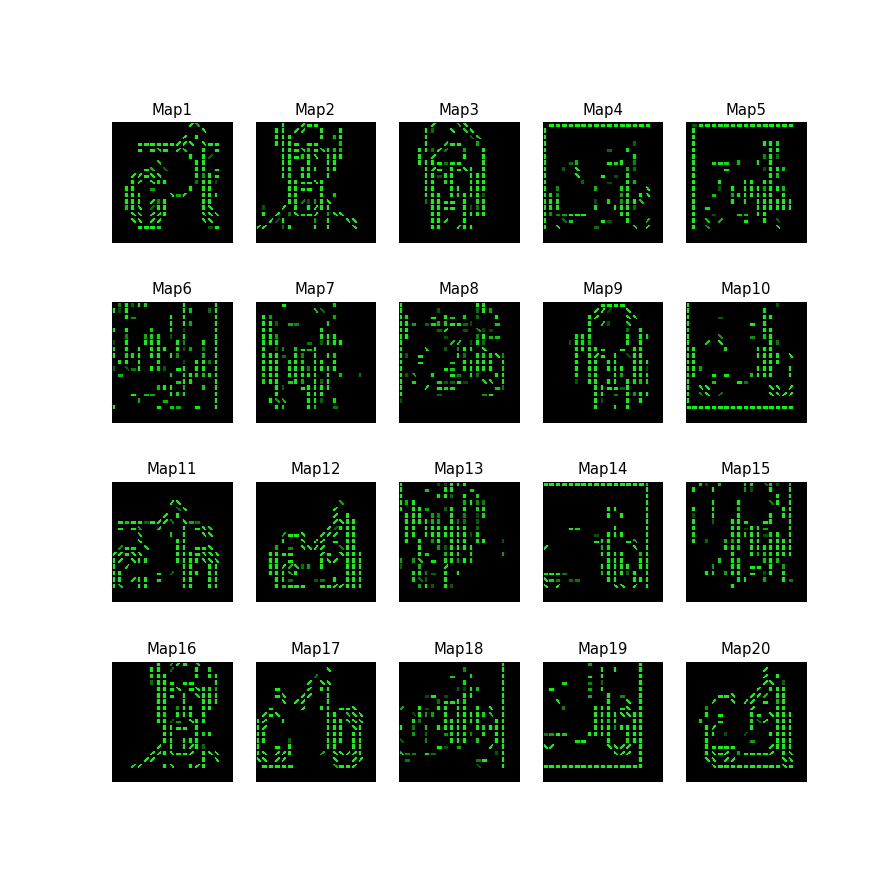

In [43]:
layer_num = [2,3,4]
filter_sizes = [net1.conv_kernel_size,net2.pool_kernel_size,net3.conv_kernel_size] ##[list of synapses from  first to last layers]
filter_strides = [1,7,1]
nof_filters = [net1.output_channels,net2.output_channels,net3.output_channels] ##[list of number of filters from first to last layers]
types = ['conv','pool','conv']
currLayer= 4
layer_weights=[[net1.evol_weights],[net3.evol_weights]]
plotx=10
ploty=10
fig = net3.feature_visualization(layer_weights,sample_interval,intervals,plotx=4,ploty=5,layer_num=layer_num,\
                          filter_sizes=filter_sizes,filter_strides=filter_strides,nof_filters=nof_filters,\
                          types=types,currLayer=currLayer,show=True)

## Feature animation for L4

<IPython.core.display.Javascript object>


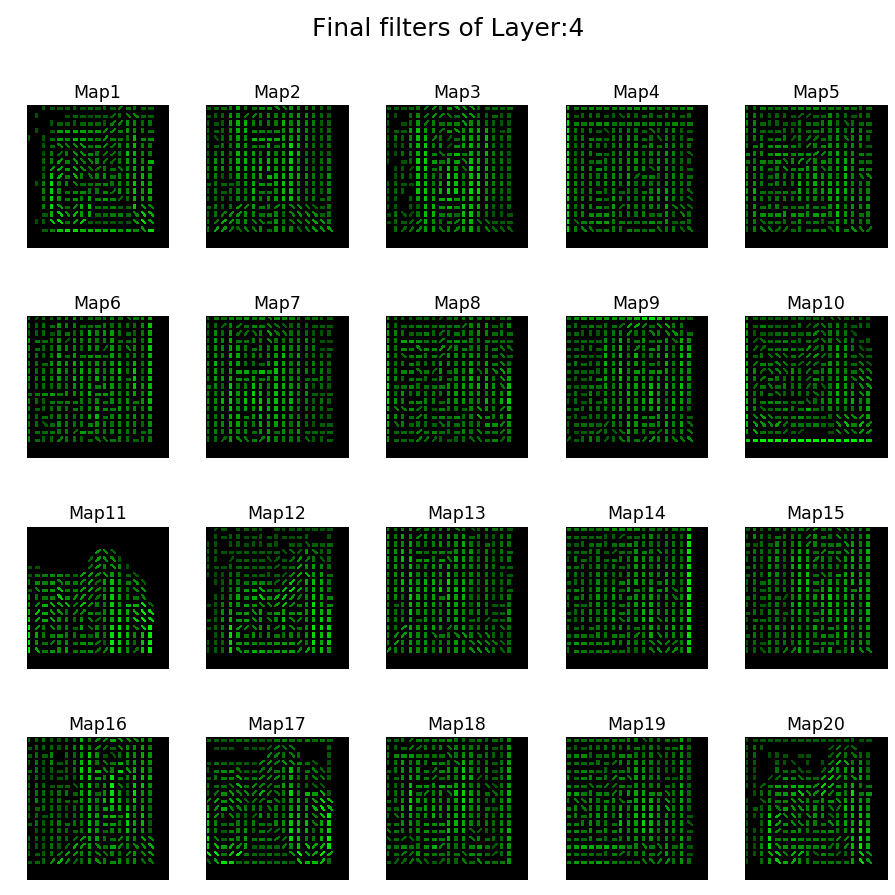

In [44]:
animation, fig = net3.animation(layer_weights,sample_interval,intervals,plotx=4,ploty=5,layer_num=layer_num,\
                              filter_sizes=filter_sizes,filter_strides=filter_strides,nof_filters=nof_filters,\
                              types=types,currLayer=currLayer)

In [45]:
HTML(animation.to_html5_video())

# Fix the weights of Conv2 (L4) and collect the spikes in pool2 (L5)

In [46]:
l5_maps = 20
pool2_lateral = True
evolved_weights = net3.evol_weights[-1]
size = net2.pool_spike_tensor.shape[0]
input_channels = net2.pool_spike_tensor.shape[2]
net4 = network.Network(pool_lateral_inh= pool2_lateral,inputs=net2.pool_spike_tensor,debug=False,output_channels=l5_maps,\
                       size=size, input_channels=input_channels, train=False, threshold=60.0,epochs=1, conv_kernel_size=17,\
                       set_weights=evolved_weights, save_pool_spike_tensor=True)

net4.feedforward()


Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 264 265 266 267 268 269 270 271 272 273 274 275
 276 2

Epoch:0 is done!


## Plot spikes per map per label in L5

<IPython.core.display.Javascript object>


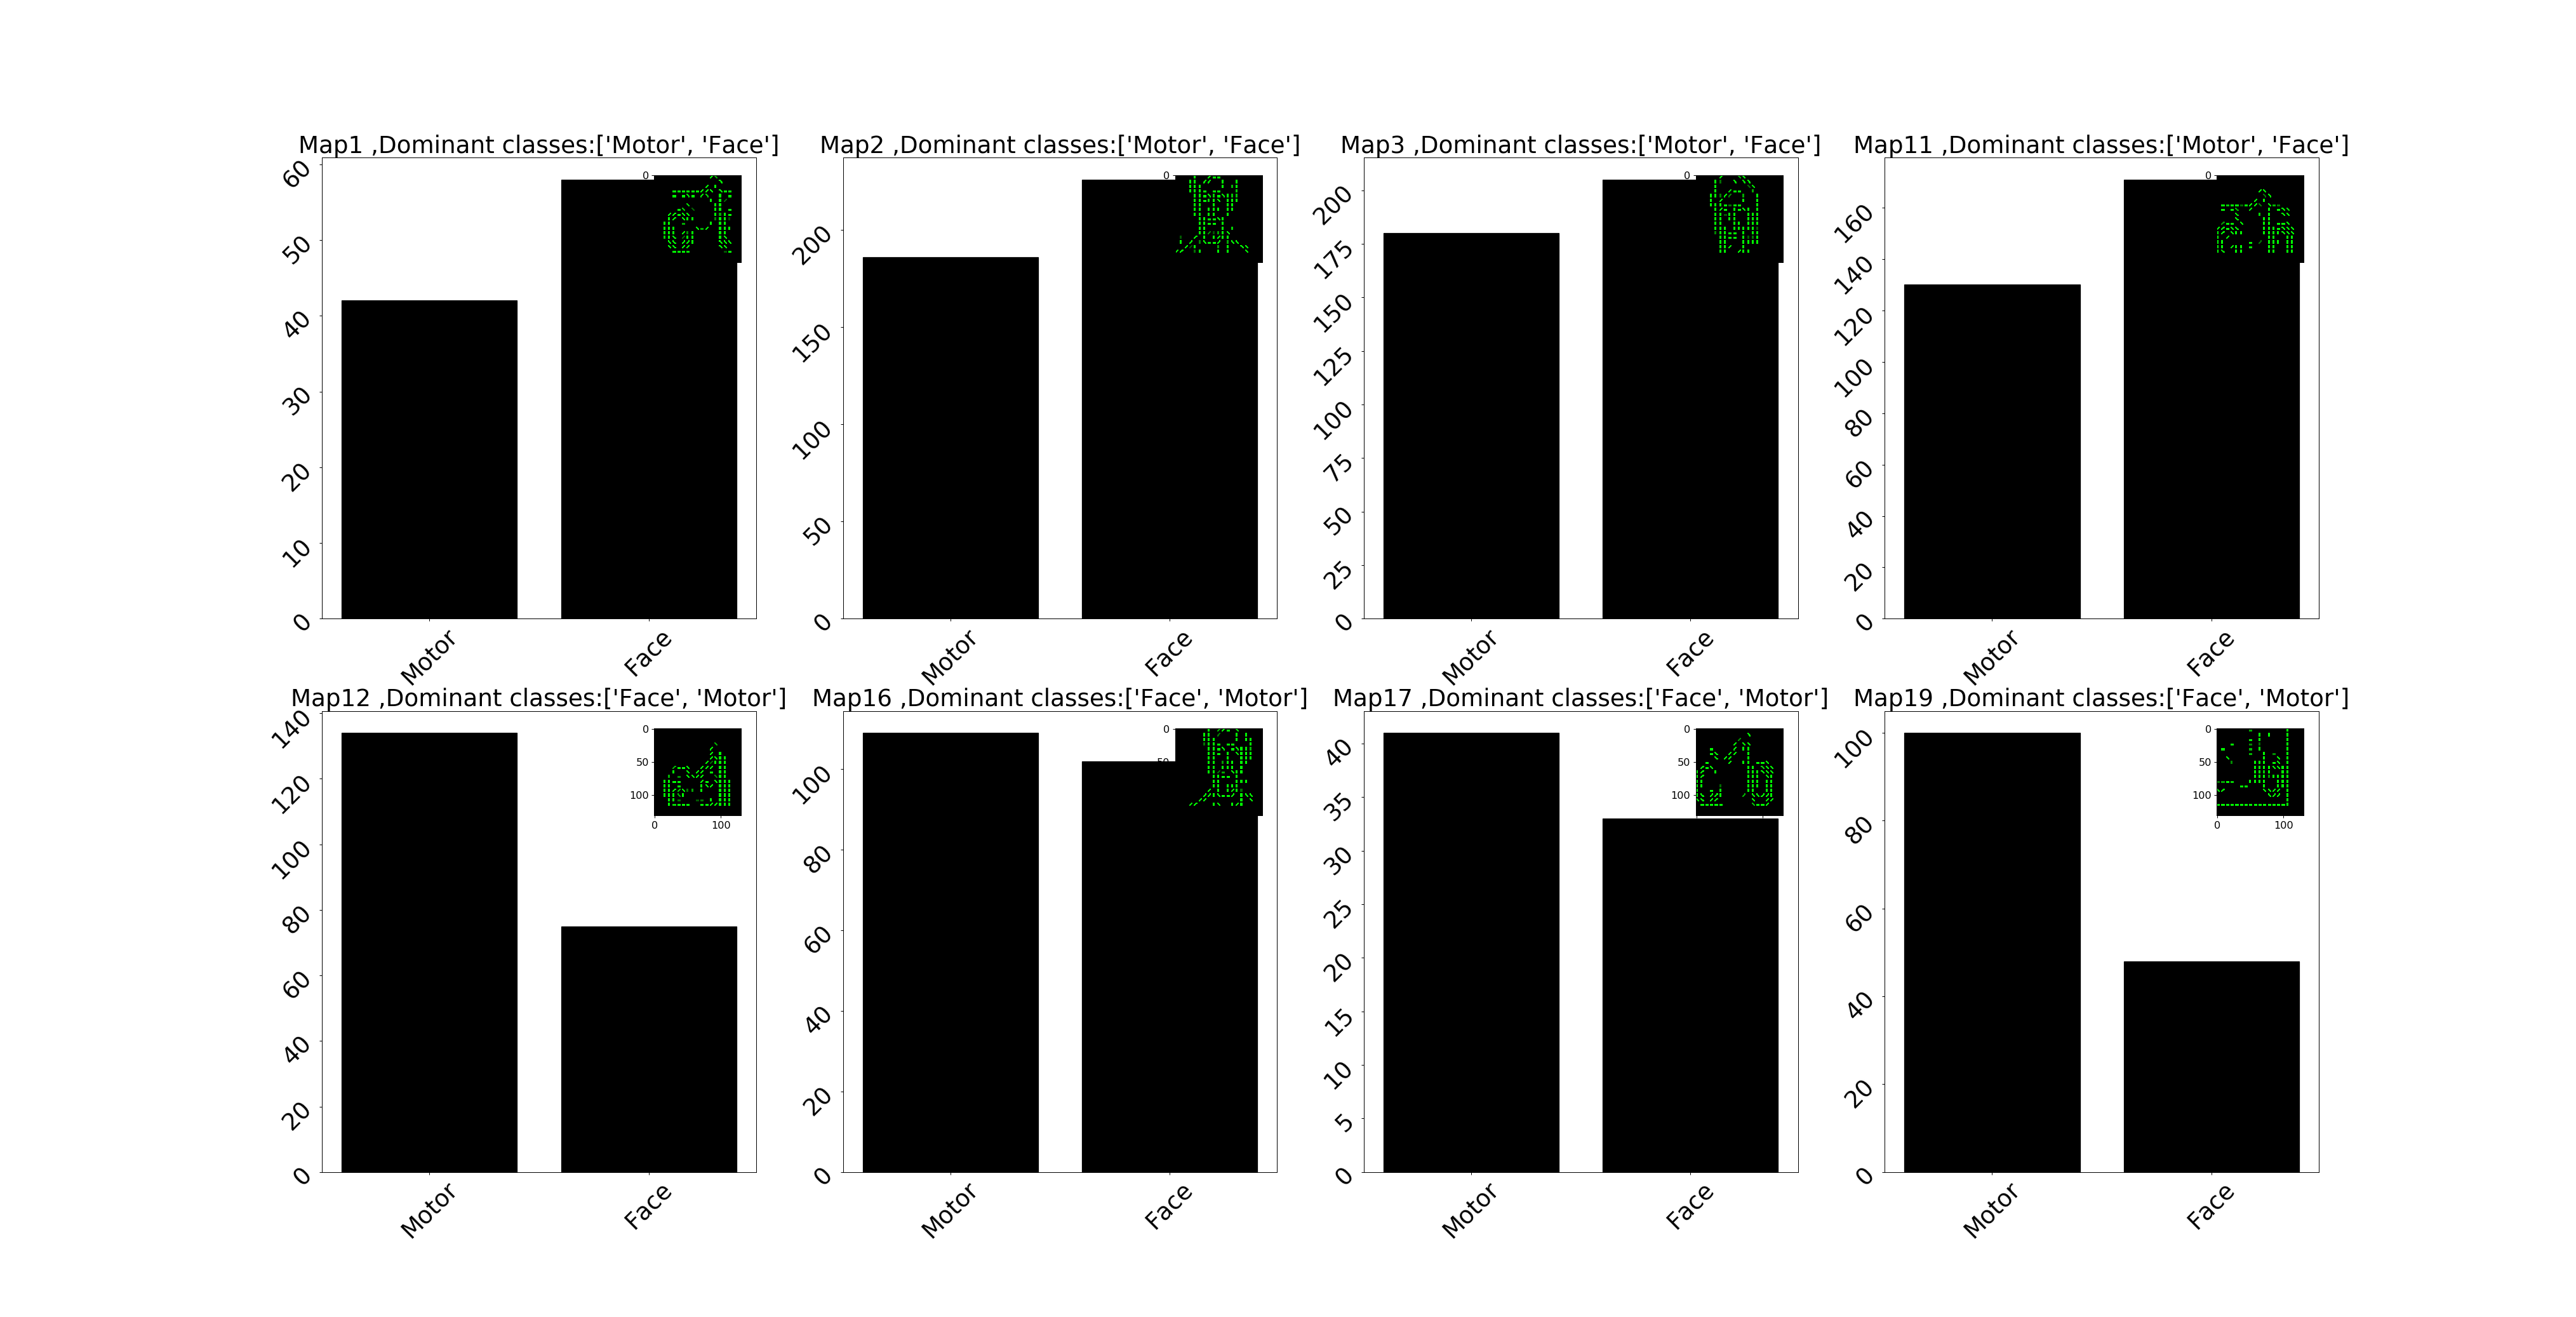

TOTAL NUMBER OF SPIKES IN POOL1 TIME TENSOR IN PLOTS:1840
TOTAL NUMBER OF SPIKES IN POOL1 TIME TENSOR:3592


In [51]:
fig = net4.spikes_per_map_per_class(plot_x=4,plot_y=2,class_labels=class_labels_train,\
                                    pool_output_data=net4.pool_spike_tensor,\
                                  labels_map=labels_map, font_size=30, inset_tick_size=13,\
                                    tick_size=30, view_maps=[1, 2, 3, 11, 12, 16, 17, 19],\
                                    final_weights=net3.final_features, figsize=(20,16))

